Train/Test data and run Poisson Regression on it before fine tuning model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_poisson_deviance

# Load data
sdd_df = pd.read_csv("species_distribution_data.csv")

In [2]:
infile = 'species_distribution_data.csv'

#end teh cell by visualizing teh data variable, if that is what you called it, axampe:
sdd_df.head()

,Transect,Biomass_g,MAD_mm,Length_mm,Angle_degree,Abundance,Latitude,Longitude,Management,Aspect,...,Profile_curvature,Proximity_index,Diversity,Sin_aspect,Slope,Slope_240,Slope_of_slope,Slope_of_slope_240,Wave_power,Site
0,PUP001,38.822840,628.600075,182.877062,13.639938,32,21.64489,-158.06639,1,1.625240,...,0.042634,0.000000,0.000000,-0.975315,6.09320,24.146000,21.80130,63.278702,14853.09961,PUP
1,PUP004,0.128699,292.160633,71.656667,10.811333,3,21.64273,-158.06592,1,0.766820,...,0.108896,0.000000,0.392213,-0.891849,4.09235,20.038700,12.58540,56.340500,14051.79980,PUP
2,PUP005,6.621155,517.647220,189.868200,17.229000,10,21.64514,-158.06548,1,0.558452,...,0.127880,0.000000,0.000000,-0.962263,3.14368,22.268801,9.83043,60.569500,14850.79980,PUP
3,PUP006,42.078543,927.395400,885.899000,17.002000,1,21.64744,-158.06490,1,1.464790,...,0.006456,0.124439,0.337360,-0.602419,3.51514,24.670900,12.88270,64.306198,15294.09961,PUP
4,PUP007,3.439379,675.913164,158.448636,16.340727,11,21.64641,-158.06582,1,0.818221,...,0.265389,0.361313,0.477289,-0.746824,4.10014,24.321699,14.21770,63.686298,15186.20020,PUP


In [3]:

#import the species distribution data file, then get columns I want for the training
Poisson_file = sdd_df
X = Poisson_file[['Bathymetry','Management','CCA_cover','Macroalgae_cover','Coral_cover','Turf_cover']]
Y = Poisson_file['Abundance']
print(np.shape(X))
print(np.shape(Y))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split data set to train/test 20/80 split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

(120, 6)
(120,)


In [4]:
model = PoissonRegressor(alpha=0.0, max_iter=500)
model.fit(X_train, Y_train)

,alpha,0.0
,fit_intercept,True
,solver,'lbfgs'
,max_iter,500
,tol,0.0001
,warm_start,False
,verbose,0


In [5]:
y_pred = model.predict(X_test)

deviance = mean_poisson_deviance(Y_test, y_pred)
print("Mean Poisson Deviance:", deviance)

Mean Poisson Deviance: 8.701333090600764


In [6]:
coef_df = pd.DataFrame({
    "Predictor": X.columns,
    "Coefficient": model.coef_,
    "Exp(Coefficient)": np.exp(model.coef_)  # multiplicative effect
})

print(coef_df)

          Predictor  Coefficient  Exp(Coefficient)
0        Bathymetry    -0.001276          0.998725
1        Management     0.809970          2.247841
2         CCA_cover     0.008642          1.008679
3  Macroalgae_cover    -0.002506          0.997498
4       Coral_cover    -0.003591          0.996416
5        Turf_cover     0.001471          1.001472


In [7]:
sdd_df["predicted_abundance"] = model.predict(scaler.transform(X))

c:\Users\dassoc\.conda\envs\sklearn-env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PoissonRegressor was fitted with feature names
  warnings.warn(


Graphs to visualize data

C:\Users\dassoc\AppData\Local\Temp\ipykernel_18100\2096450831.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="ExpCoef", y="Predictor", ax=ax, palette="crest")
C:\Users\dassoc\AppData\Local\Temp\ipykernel_18100\2096450831.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


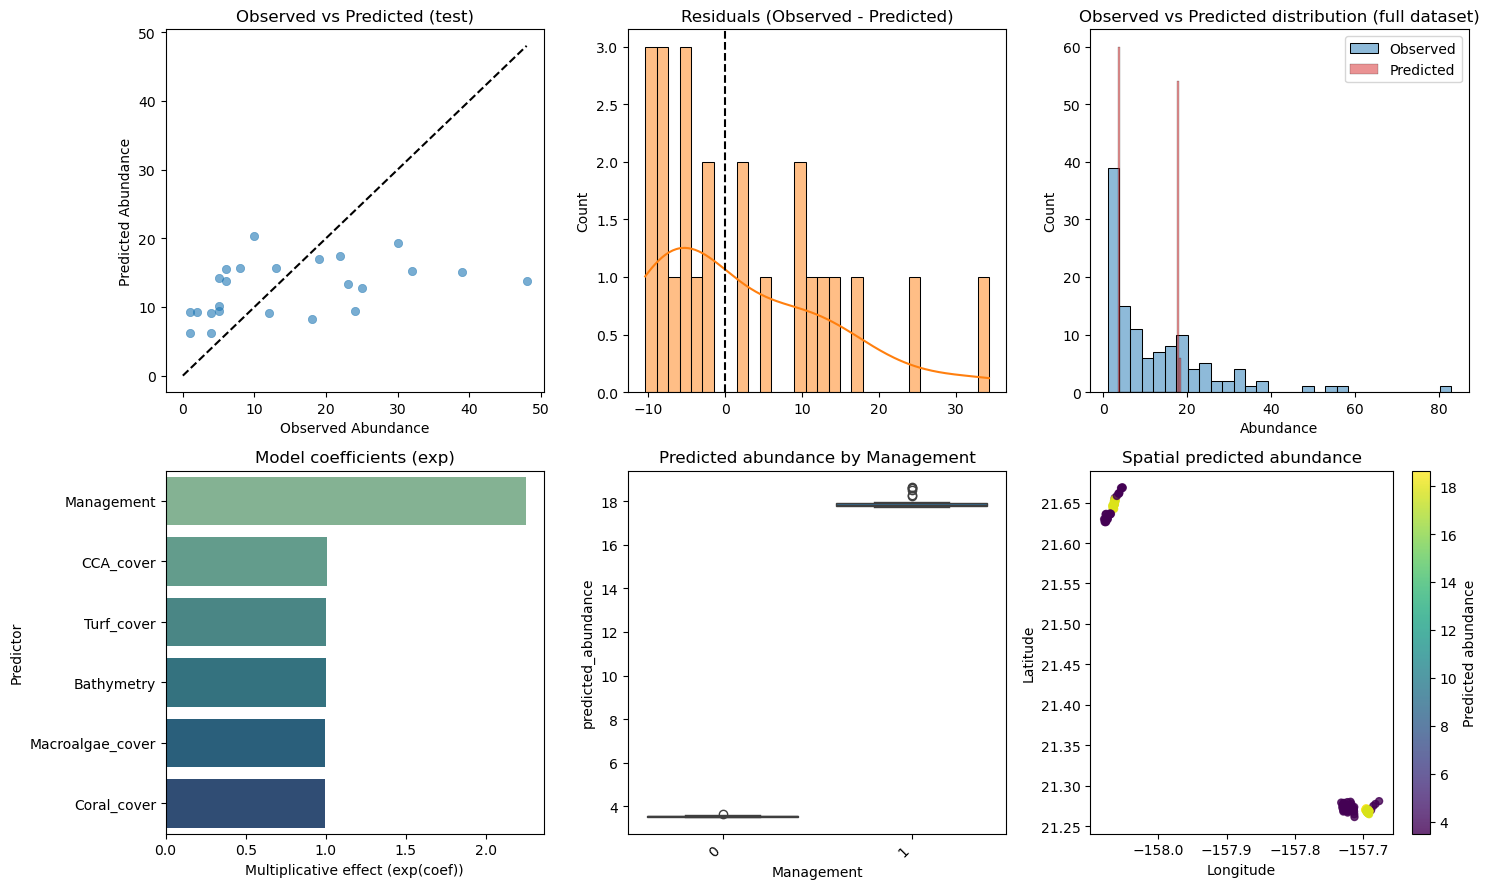

In [20]:
# 2x3 grid of simple diagnostics
fig, axes = plt.subplots(2, 3, figsize=(15, 9))
axes = axes.ravel()

# 1) Observed vs Predicted (test set) with 1:1 line
ax = axes[0]
sns.scatterplot(x=y_obs, y=y_pred, ax=ax, alpha=0.6, edgecolor=None)
mx = max(y_obs.max(), y_pred.max())
ax.plot([0, mx], [0, mx], '--', color='k')
ax.set_xlabel("Observed Abundance")
ax.set_ylabel("Predicted Abundance")
ax.set_title("Observed vs Predicted (test)")

# 2) Residuals histogram
ax = axes[1]
resid = y_obs - y_pred
sns.histplot(resid, bins=30, kde=True, ax=ax, color='C1')
ax.axvline(0, color='k', linestyle='--')
ax.set_title("Residuals (Observed - Predicted)")

# 3) Overlaid histograms: observed vs predicted (full)
ax = axes[2]
sns.histplot(sdd_df['Abundance'].dropna(), bins=30, color='C0', alpha=0.5, label='Observed', ax=ax)
sns.histplot(sdd_df['predicted_abundance'].dropna(), bins=30, color='C3', alpha=0.5, label='Predicted', ax=ax)
ax.legend()
ax.set_title("Observed vs Predicted distribution (full dataset)")

# 4) Coefficients (exp) bar chart
ax = axes[3]
try:
    coef_df = pd.DataFrame({
        "Predictor": X.columns,
        "Coefficient": model.coef_,
        "ExpCoef": np.exp(model.coef_)
    }).sort_values("ExpCoef", ascending=False)
    sns.barplot(data=coef_df, x="ExpCoef", y="Predictor", ax=ax, palette="crest")
    ax.set_xlabel("Multiplicative effect (exp(coef))")
    ax.set_title("Model coefficients (exp)")
except Exception:
    ax.text(0.5, 0.5, "Coefficients not available", ha='center')
    ax.set_axis_off()

# 5) Boxplot of predicted abundance by Management (if present)
ax = axes[4]
if 'Management' in sdd_df.columns:
    sns.boxplot(data=sdd_df, x='Management', y='predicted_abundance', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title("Predicted abundance by Management")
else:
    ax.text(0.5, 0.5, "Management column not found", ha='center')
    ax.set_axis_off()

# 6) Spatial scatter colored by predicted abundance (if coords present)
ax = axes[5]
if {'Latitude', 'Longitude', 'predicted_abundance'}.issubset(sdd_df.columns):
    sc = ax.scatter(sdd_df['Longitude'], sdd_df['Latitude'],
                    c=sdd_df['predicted_abundance'], cmap='viridis', s=25, alpha=0.8)
    fig.colorbar(sc, ax=ax, label='Predicted abundance')
    ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    ax.set_title('Spatial predicted abundance')
else:
    ax.text(0.5, 0.5, "Latitude/Longitude not found", ha='center')
    ax.set_axis_off()

plt.tight_layout()
plt.show()
# ...existing code...

In [22]:
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
import numpy as np

# Data
Poisson_file = sdd_df
X = Poisson_file[['Bathymetry','Management','CCA_cover','Macroalgae_cover','Coral_cover','Turf_cover']]
Y = Poisson_file['Abundance']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LOOCV
loo = LeaveOneOut()

y_true = []
y_pred = []

# LOOCV loop
for train_index, test_index in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Poisson regression model
    poisson = PoissonRegressor(alpha=0.0, max_iter=1000)
    poisson.fit(X_train, Y_train)
    
    prediction = poisson.predict(X_test)[0]
    
    y_true.append(Y_test.values[0])
    y_pred.append(prediction)

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Optional: evaluate
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("LOOCV R²:", r2)
print("LOOCV MSE:", mse)
print("LOOCV RMSE:", rmse)

LOOCV R²: 0.012293952830771615
LOOCV MSE: 179.38278248222116
LOOCV RMSE: 13.393385773665342


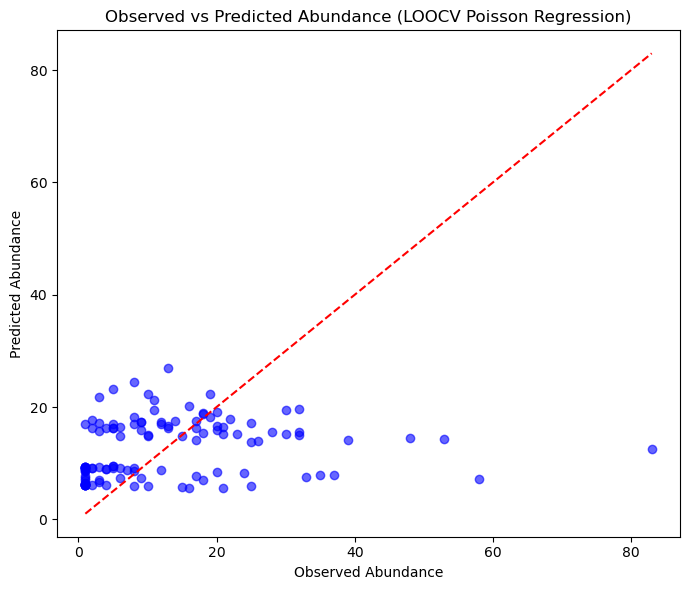

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,6))

# Scatter plot of observed vs predicted
plt.scatter(y_true, y_pred, alpha=0.6, color='blue')

# 1:1 reference line (perfect prediction)
plt.plot([min(y_true), max(y_true)],
         [min(y_true), max(y_true)],
         linestyle='--', color='red')

plt.xlabel("Observed Abundance")
plt.ylabel("Predicted Abundance")
plt.title("Observed vs Predicted Abundance (LOOCV Poisson Regression)")
plt.tight_layout()
plt.show()